In [2]:
!pip install --upgrade pip
!pip uninstall tensorflow --y
!pip install tensorflow

  Using cached tensorflow-2.13.0rc2-cp310-cp310-macosx_12_0_arm64.whl (2.0 kB)
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/189.3 MB 5.6 kB/s eta 9:14:50m
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/charan/anaconda3/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/Users/charan/anaconda3/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "/Users/charan/anaconda3/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/Users/charan/anaconda3/lib/python3.10/site-packages/pip/_vendor/cachecontrol/filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "/Users/charan/anaconda3/lib/python3.10/http/client.py", line 465, in read
    s = self.fp.read(amt)
  File "/Users/charan/anaconda3/lib/pyt

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout


from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
data_train = pd.read_csv("/Users/charan/Downloads/Quantum-Supply-Chain-Manager-main/dataset/fair_train.csv")
X_train,y_train = data_train[data_train.columns[:16]].values, data_train[data_train.columns[16]].values

data_test = pd.read_csv("/Users/charan/Downloads/Quantum-Supply-Chain-Manager-main/dataset/classic_test.csv")
X_test,y_test = data_test[data_test.columns[:16]].values, data_test[data_test.columns[16]].values

(X_train.shape, y_train.shape),(X_test.shape, y_test.shape)

(((2000, 16), (2000,)), ((6159, 16), (6159,)))

###### Random seed for reproducibility

In the same case of reproducing the code it is important to consider the numpy seed, for this purpose the following cell is used

In [7]:
np.random.seed(123)
tf.random.set_seed(123)

For neuran networks is important to normalize and check the distribution of the variables for that exist the variable StandarScaler that 
    - Scaling by Normalization or min-max scaling
    - Scaling by mean and standard deviation or standardization
    
1. StandardScaler is a function used to standardize the data .
2. Standardized value for x is computed as (x-mean(column))/standard deviation(column). 

In [8]:
scale = StandardScaler()

In [9]:
scale.fit(X_train)

StandardScaler()

Apply the StandardScaler to the train and test sets

In [10]:
X_train_std = scale.transform(X_train)
X_test_std = scale.transform(X_test)

Check the values after that

In [11]:
X_train_std[1], y_train[1]

(array([-0.08878785,  0.99245064, -0.07217543, -0.12087906, -0.13114244,
        -0.1312855 , -0.08861196, -0.08968266, -0.09519565, -0.10915324,
        -0.07271837, -0.07898323,  0.27210453,  0.19214586, -0.09095412,
         0.3788279 ]),
 0)

## The model 
Using the same classical model with a balance close to 50% for both classes.

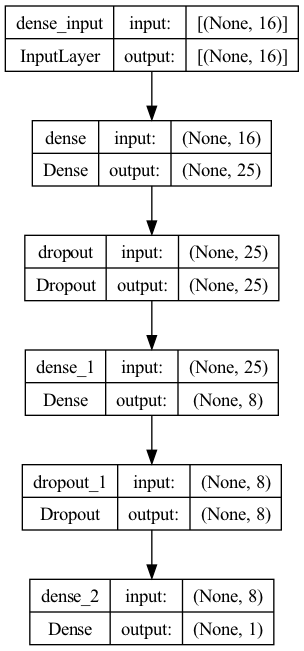

In [12]:
model = Sequential()

model.add(Dense(25, input_dim=16, activation='relu', kernel_regularizer=l2(1e-6),kernel_initializer="glorot_normal"))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu',kernel_regularizer=l2(1e-6), kernel_initializer="glorot_normal"))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(1e-6), kernel_initializer="glorot_normal"))

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Since they are unbalanced values, it is common to deal with the Area under the ROC Curve(AUC)

this works  using True Positive Rate and False Positive Rate, where they are defined as :

- **True Positive Rate (TPR)** is a synonym for recall and is therefore defined as follows:
$$
T P R=\frac{T P}{T P+F N}
$$
- **False Positive Rate (FPR)** is defined as follows:
$$
F P R=\frac{F P}{F P+T N}
$$

metric instead of accuracy, therefore both were selected to train the model with the Adam optimizer. Using binary crossentropy because is a binary classification 

$$\operatorname{Loss}=-\frac{1}{\begin{array}{c}
\text { output } \\
\text { size }
\end{array}} \sum_{i=1}^{\substack{\text { output } \\
\text { size }}} y_{i} \cdot \log \hat{y}_{i}+\left(1-y_{i}\right) \cdot \log \left(1-\hat{y}_{i}\right).
$$

In [13]:
# Compile model
auc = tf.keras.metrics.AUC()
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy',auc])

Using 100 epochs a batch size of 32, with a validation split of 0.2 of the  train data

In [14]:
model_history = model.fit(X_train_std, y_train, epochs=100,
                                        batch_size=32, 
                                        validation_split=0.2, shuffle=True)

Epoch 1/100
50/50 [==============================] - 0s 2ms/step - loss: 0.7649 - accuracy: 0.5562 - auc: 0.5035 - val_loss: 0.7450 - val_accuracy: 0.1675 - val_auc: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 0s 578us/step - loss: 0.7100 - accuracy: 0.6037 - auc: 0.5046 - val_loss: 0.7885 - val_accuracy: 0.0875 - val_auc: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 0s 541us/step - loss: 0.6933 - accuracy: 0.6100 - auc: 0.5032 - val_loss: 0.8033 - val_accuracy: 0.0825 - val_auc: 0.0000e+00
Epoch 4/100
50/50 [==============================] - 0s 534us/step - loss: 0.7005 - accuracy: 0.6137 - auc: 0.5080 - val_loss: 0.8206 - val_accuracy: 0.0750 - val_auc: 0.0000e+00
Epoch 5/100
50/50 [==============================] - 0s 528us/step - loss: 0.6759 - accuracy: 0.6237 - auc: 0.5349 - val_loss: 0.8333 - val_accuracy: 0.0625 - val_auc: 0.0000e+00
Epoch 6/100
50/50 [==============================] - 0s 524us/step - loss: 0.6701 - accuracy: 0.6325 - auc:

50/50 [==============================] - 0s 505us/step - loss: 0.5638 - accuracy: 0.6869 - auc: 0.7499 - val_loss: 0.8726 - val_accuracy: 0.2925 - val_auc: 0.0000e+00
Epoch 92/100
50/50 [==============================] - 0s 503us/step - loss: 0.5617 - accuracy: 0.6906 - auc: 0.7560 - val_loss: 0.8780 - val_accuracy: 0.2800 - val_auc: 0.0000e+00
Epoch 93/100
50/50 [==============================] - 0s 508us/step - loss: 0.5665 - accuracy: 0.6862 - auc: 0.7494 - val_loss: 0.8562 - val_accuracy: 0.3475 - val_auc: 0.0000e+00
Epoch 94/100
50/50 [==============================] - 0s 504us/step - loss: 0.5598 - accuracy: 0.7013 - auc: 0.7565 - val_loss: 0.8825 - val_accuracy: 0.3200 - val_auc: 0.0000e+00
Epoch 95/100
50/50 [==============================] - 0s 505us/step - loss: 0.5587 - accuracy: 0.6950 - auc: 0.7618 - val_loss: 0.8268 - val_accuracy: 0.4000 - val_auc: 0.0000e+00
Epoch 96/100
50/50 [==============================] - 0s 507us/step - loss: 0.5648 - accuracy: 0.6900 - auc: 0.74

## Predictions

After that we used the predictions  of the  train and test set

In [15]:
train_pred = model.predict(X_train_std)
test_pred = model.predict(X_test_std)

193/193 [==============================] - 0s 178us/step


to convert the predict values into the classes was designed an condition that looks as 

In [16]:
y_train_pred = (model.predict(X_train_std) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test_std) > 0.5).astype("int32")

193/193 [==============================] - 0s 177us/step


### Getting evaluation metrics and evaluating model performance

Using different metrics as 

- accuracy
- precision
- recall
- f1 score
- cohen_kappa
- roc_auc


The results of the train are important to check the F1 score and ROC AUC, they are 

- F1 score: 0.413999
- ROC AUC: 0.606500

they are worst with respect the imbalance but good to comapre with a quantum model

In [21]:
accuracy = accuracy_score(y_train, y_train_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_train_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_train_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_train_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_train, y_train_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_train_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
train_matrix = confusion_matrix(y_train, y_train_pred)
print(train_matrix)
ax = sns.heatmap(train_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

NameError: name 'accuracy_score' is not defined

The results of the test are important to check the F1 score and ROC AUC, they are 

- F1 score: 0.338028
- ROC AUC: 0.598467

they are worst with respect the imbalance but good to comapre with a quantum model

Accuracy: 0.809222
Precision: 0.464396
Recall: 0.265722
F1 score: 0.338028
Cohens kappa: 0.236103
ROC AUC: 0.598467
[[4684  346]
 [ 829  300]]


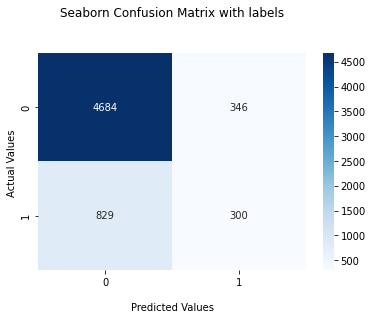

In [16]:
accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_test_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_test_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_test_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, y_test_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_test_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
test_matrix = confusion_matrix(y_test, y_test_pred)
print(test_matrix)
ax = sns.heatmap(test_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()